
📊 Model Evaluation Results:
Linear Regression -> R²: 0.8823, MAE: 3.4763, RMSE: 5.9856, Max Error: 51.96


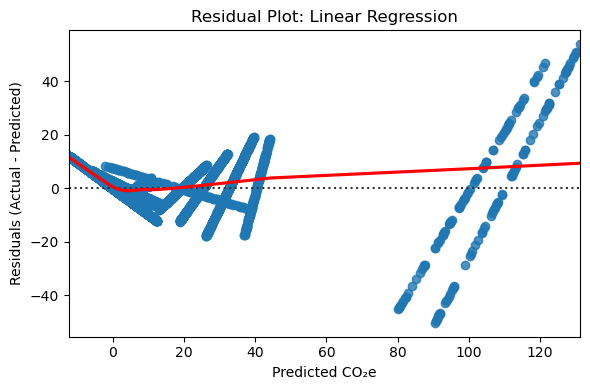

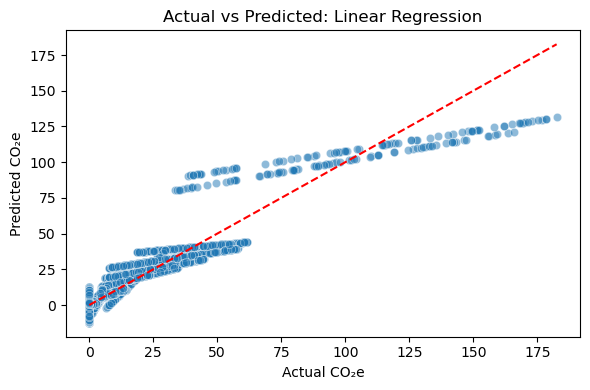

Decision Tree -> R²: 1.0000, MAE: 0.0067, RMSE: 0.0463, Max Error: 2.54


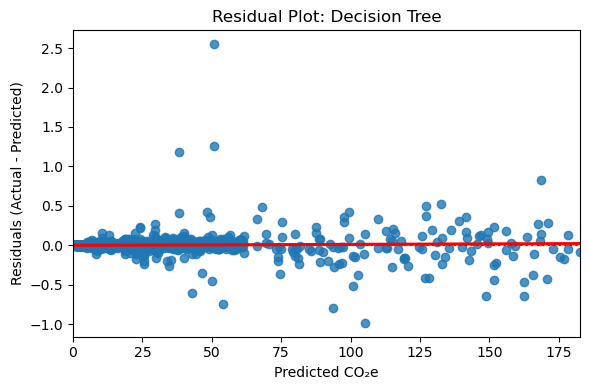

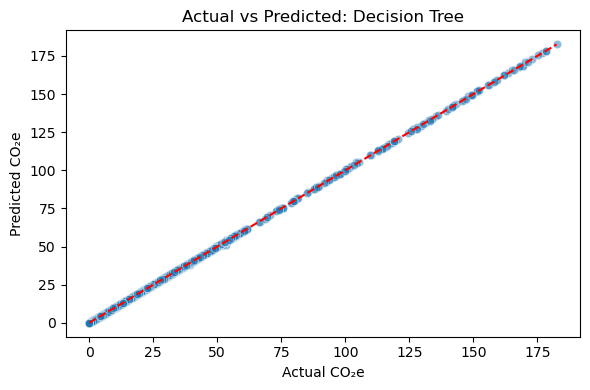

Random Forest -> R²: 1.0000, MAE: 0.0059, RMSE: 0.0526, Max Error: 3.11


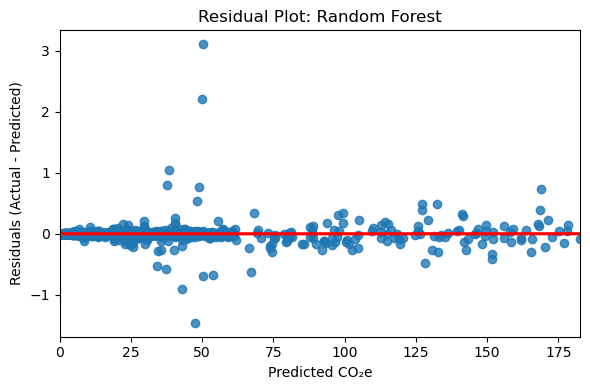

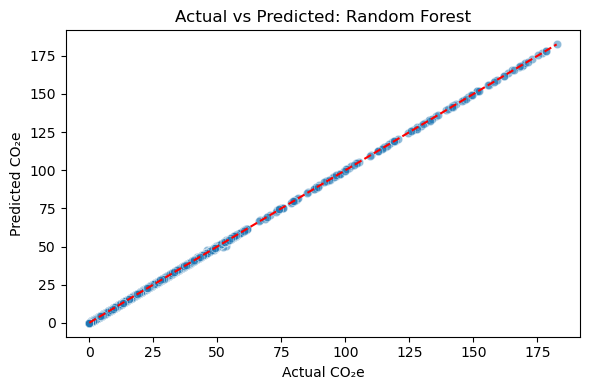

SVR -> R²: 0.2829, MAE: 7.3433, RMSE: 14.7749, Max Error: 114.09


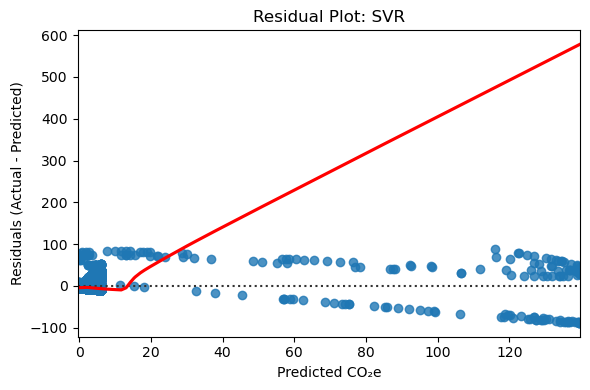

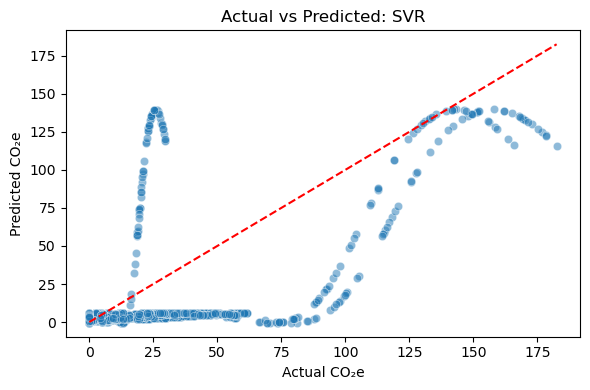

KNN -> R²: 0.6966, MAE: 2.1705, RMSE: 9.6108, Max Error: 136.41


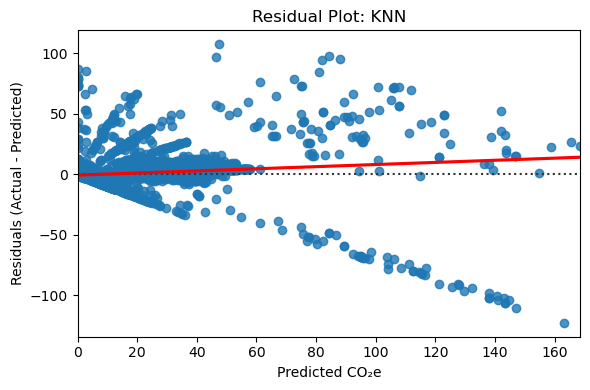

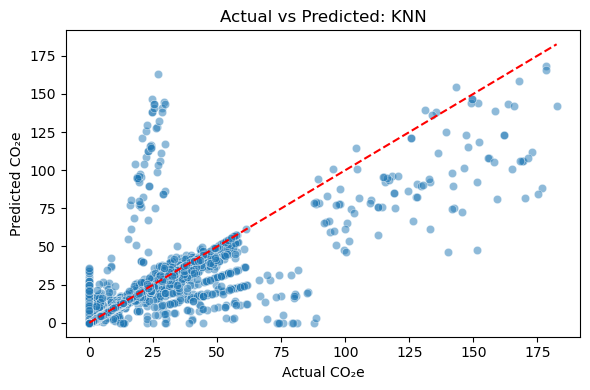

MLP -> R²: 0.9953, MAE: 0.7339, RMSE: 1.1969, Max Error: 14.97


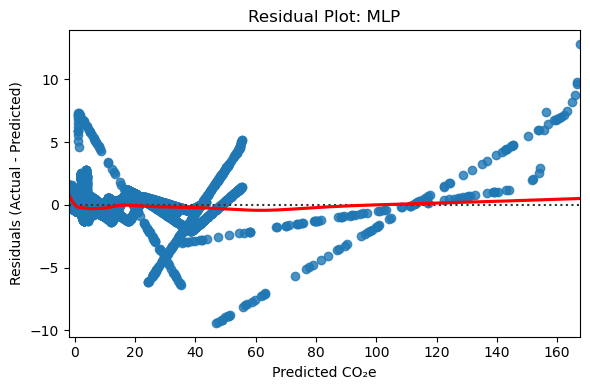

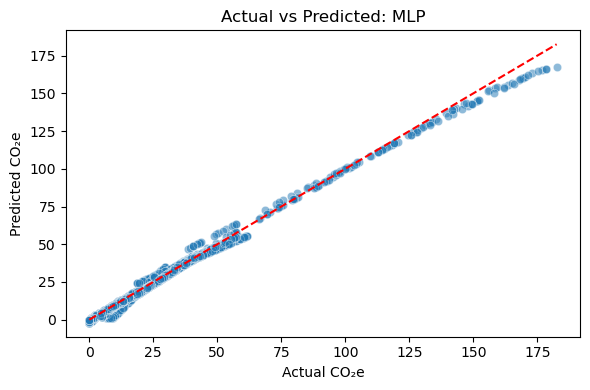


📋 Model Comparison Table:


,Model,R²,MAE,RMSE,Max Error
0,Decision Tree,0.999993,0.006709,0.046259,2.544000
1,Random Forest,0.999991,0.005946,0.052593,3.108430
2,MLP,0.995294,0.733942,1.196852,14.965325
3,Linear Regression,0.882306,3.476328,5.985604,51.963921
4,KNN,0.696571,2.170532,9.610790,136.413200
5,SVR,0.282888,7.343285,14.774886,114.087638



✅ Saved best model: Decision Tree with R² = 1.0000 as 'best_co2_model.pkl'


In [1]:
%matplotlib inline

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error

# === Suppress FutureWarnings ===
warnings.filterwarnings("ignore", category=FutureWarning)

# === Load dataset ===
df = pd.read_excel(r"C:\Users\preeti123\Desktop\PREETI\carbon footprint\Transactions_dataset_with_CO2.xlsx")
df_sample = df.sample(n=50000, random_state=42)

X = df_sample[["Amount", "Category", "Subcategory"]]
y = df_sample["Estimated_CO2e"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Preprocessing ===
preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="mean"), ["Amount"]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["Category", "Subcategory"])
])

# === Models ===
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

results = {}
print("\n📊 Model Evaluation Results:")
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    maxerr = max_error(y_test, y_pred)

    results[name] = {
        "pipeline": pipeline,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse,
        "Max Error": maxerr,
        "y_pred": y_pred
    }

    print(f"{name} -> R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, Max Error: {maxerr:.2f}")

    # === Residual Plot ===
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.xlabel("Predicted CO₂e")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residual Plot: {name}")
    plt.tight_layout()
    plt.show()

    # === Predicted vs Actual Plot ===
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual CO₂e")
    plt.ylabel("Predicted CO₂e")
    plt.title(f"Actual vs Predicted: {name}")
    plt.tight_layout()
    plt.show()

# === Show All Model Performance in a Table ===
comparison_df = pd.DataFrame([
    {
        "Model": name,
        "R²": metrics["R2"],
        "MAE": metrics["MAE"],
        "RMSE": metrics["RMSE"],
        "Max Error": metrics["Max Error"]
    }
    for name, metrics in results.items()
])
# Sort by R² descending
comparison_df = comparison_df.sort_values(by="R²", ascending=False).reset_index(drop=True)

print("\n📋 Model Comparison Table:")
display(comparison_df)

# === Select and save best model ===
best_model_name = max(results, key=lambda x: results[x]["R2"])
best_pipeline = results[best_model_name]["pipeline"]
best_r2 = results[best_model_name]["R2"]

joblib.dump(best_pipeline, "best_co2_model.pkl")
print(f"\n✅ Saved best model: {best_model_name} with R² = {best_r2:.4f} as 'best_co2_model.pkl'")


In [9]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load("best_co2_model.pkl")

# Category → Subcategory map
category_subcategory_map = {
    "Food": ["Plant-Based", "Dairy", "Non-Veg"],
    "Transport": ["Taxi", "Public Transport"],
    "Shopping": ["Online", "Offline"],
    "Groceries": ["Fruits", "Vegetables", "Packaged"],
    "Utilities": ["Electricity", "Water", "Internet"],
    "Fuel & Energy": ["Petrol", "Diesel", "LPG"],
    "Travel": ["Flight", "Hotel", "Train"],
    "Education": [],
    "Miscellaneous": []
}

print("\n🌱 Welcome to the Carbon Footprint Estimator 🌍")

# Category dropdown
categories = list(category_subcategory_map.keys())
print("\nCategory Options:")
for i, cat in enumerate(categories, start=1):
    print(f"{i}. {cat}")

while True:
    try:
        # Amount input
        amount = float(input("\nEnter transaction amount (INR): "))

        # Category input
        cat_input = input("Enter category number: ")
        if not cat_input.isdigit() or not (1 <= int(cat_input) <= len(categories)):
            print("❌ Invalid category choice. Please enter a valid number.")
            continue

        category = categories[int(cat_input) - 1]

        # Subcategory dropdown
        subcategories = category_subcategory_map[category]
        if subcategories:
            print("\nSubcategory Options:")
            for i, subcat in enumerate(subcategories, start=1):
                print(f"{i}. {subcat}")
            
            sub_input = input("Enter subcategory number: ")
            if not sub_input.isdigit() or not (1 <= int(sub_input) <= len(subcategories)):
                print("❌ Invalid subcategory choice. Please enter a valid number.")
                continue

            subcategory = subcategories[int(sub_input) - 1]
        else:
            subcategory = "None"

        # Predict
        if subcategory in ["None", "Fruits", "Vegetables", "Plant-Based", "Water", "Internet"]:
            prediction = 0.0
        else:
            input_df = pd.DataFrame([{
                "Amount": amount,
                "Category": category,
                "Subcategory": subcategory
            }])
            prediction = model.predict(input_df)[0]

        print(f"\n✅ Estimated CO₂ emission: {prediction:.2f} kg")
        
        # Continue or exit
        cont = input("\n🔁 Do you want to make another prediction? (y/n): ").strip().lower()
        if cont != 'y':
            print("\n👋 Thank you for using the estimator!")
            break

    except ValueError:
        print("❌ Invalid input. Please enter numeric values where expected.")



🌱 Welcome to the Carbon Footprint Estimator 🌍

Category Options:
1. Food
2. Transport
3. Shopping
4. Groceries
5. Utilities
6. Fuel & Energy
7. Travel
8. Education
9. Miscellaneous



Enter transaction amount (INR):  150
Enter category number:  2



Subcategory Options:
1. Taxi
2. Public Transport


Enter subcategory number:  1



✅ Estimated CO₂ emission: 1.99 kg



🔁 Do you want to make another prediction? (y/n):  y

Enter transaction amount (INR):  250
Enter category number:  4



Subcategory Options:
1. Fruits
2. Vegetables
3. Packaged


Enter subcategory number:  3



✅ Estimated CO₂ emission: 1.67 kg



🔁 Do you want to make another prediction? (y/n):  y

Enter transaction amount (INR):  750
Enter category number:  5



Subcategory Options:
1. Electricity
2. Water
3. Internet


Enter subcategory number:  3



✅ Estimated CO₂ emission: 0.00 kg



🔁 Do you want to make another prediction? (y/n):  y

Enter transaction amount (INR):  450
Enter category number:  6



Subcategory Options:
1. Petrol
2. Diesel
3. LPG


Enter subcategory number:  3



✅ Estimated CO₂ emission: 17.41 kg



🔁 Do you want to make another prediction? (y/n):  y

Enter transaction amount (INR):  4500
Enter category number:  7



Subcategory Options:
1. Flight
2. Hotel
3. Train


Enter subcategory number:  1



✅ Estimated CO₂ emission: 164.61 kg



🔁 Do you want to make another prediction? (y/n):  n



👋 Thank you for using the estimator!
